# ChemicalMotifIdentifier

This is a quick tutorial on:
1. Analytically obtaining a pattern inventory for a ternary system (CrCoNi) in the fcc crystal structure. 
1. Obtaining the pattern inventory with ML and creating a physically constrained embedding space from which we can compute dissimilarities between motifs. 
1. Computing dissimilarity between motifs in atomistic data.

In [23]:
from polya import Polya
from rich import print
from sympy import init_printing, symbols  # For latex formatting
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
%matplotlib inline  

## 1. Ternary system pattern inventory

In [ ]:

init_printing()

pl = Polya(graph_name="fcc")

ntypes = 3
p_g, nms = pl.get_gt(ntypes=ntypes)

# Replacing t1, t2 and t3 with Cr, Co, Ni.
p_g = p_g.subs(
    {
        symbols("t1"): symbols("Cr"),
        symbols("t2"): symbols("Co"),
        symbols("t3"): symbols("Ni"),
    }
)

print(
    "The pattern inventory for the fcc first coordination polyhedron of the CrCoNi system is given by: \n"
)

p_g

In [ ]:
print(
    f"\n We have a total of {nms} distinct coordination polyhedron, which in turns yield {nms*ntypes} distinct local chemical motifs. "
)

## 2. Model expressivity on the fcc ternary synthetic dataset and physically constrained embedding space

In [ ]:
 
from _frameworks import ECASyntheticFirstPaper

eca = ECASyntheticFirstPaper(crystal_structure="fcc")
df = eca.predict(
    root="data/synthetic/fcc_graph_datasets/",
    skeleton_graph_path="data/inputs_doi-10.48550-arXiv.2311.01545/fcc_1nn.pt",
    atom_types_paths=["data/inputs_doi-10.48550-arXiv.2311.01545/fcc_nelement3_generators.pt"],
    nelement=3,
)
os.makedirs("data/synthetic/outputs/", exist_ok=True)
df.to_pickle("data/synthetic/outputs/df_fcc.pkl")

In [ ]:
# Verification
df = pd.read_pickle("data/synthetic/outputs/df_fcc.pkl")

shell_concentrations, counts = np.array(list(df.shell_concentration)), np.array(list(df.counts))
unique_concentrations, counts = np.unique(shell_concentrations, axis=0,return_inverse=True)

pattern = {tuple(unique_concentrations[i]) : counts[i] for i in range(len(unique_concentrations))}
print('The machine learning pattern inventory is given by:')
print(pattern)
print(f'We have a total of {len(counts)} distinct 1CP.')

## 3. Application of the framework on atomistic data

In [ ]:
from _frameworks import ECA_MD_FirstPaper

dump_files = [
    f"data/inputs_doi-10.48550-arXiv.2311.01545/dumps/ordered_relaxation_20_{i}_300K.dump" for i in range(1, 5 + 1)
]

eca = ECA_MD_FirstPaper(crystal_structure="fcc")
df = eca.predict(root="data/mc/outputs/eca_id/300K/", dump_file=dump_files)
kl = eca.get_kl(df)
df.to_pickle("data/mc/outputs/eca_id/300K/df_microstates.pkl")

In [5]:
df = pd.read_pickle( "data/mc/outputs/eca_id/300K/df_microstates.pkl")
df.head(5)

shell_ID                         shell_phys_emb  \
central_atom_type shell_ID                                                    
0                 2293          2293  (3.0, 1.7320508075688772, 0.37284796)   
                  791            791  (3.5, 0.8660254037844386, 0.09067367)   
                  784            784  (3.5, 0.8660254037844386, 0.33462867)   
                  3099          3099  (3.5, 2.598076211353316, -0.23161014)   
                  3215          3215  (3.5, 2.598076211353316, -0.00540391)   

                            counts                    shell_atomic_types  \
central_atom_type shell_ID                                                 
0                 2293          12  (1, 0, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0)   
                  791           48  (2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0)   
                  784           12  (2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0)   
                  3099          24  (1, 0, 0, 2, 1, 2, 0, 2, 0, 0, 0, 0)   
                  3215          48  (1, 2, 0, 0, 0, 2, 1, 0, 0, 2, 0, 0)   

                           shell_concentration  central_atom_type  count_md  \
central_atom_type shell_ID                                                    
0                 2293         (8.0, 2.0, 2.0)                  0         1   
                  791          (8.0, 3.0, 1.0)                  0         1   
                  784          (8.0, 3.0, 1.0)                  0        16   
                  3099         (7.0, 2.0, 3.0)                  0         2   
                  3215         (7.0, 2.0, 3.0)                  0         1   

                                                                          emb  \
central_atom_type shell_ID                                                      
0                 2293      (8.0, 2.0, 2.0, 0.64960325, 0.3675156, -1.7443...   
                  791       (8.0, 3.0, 1.0, 0.44964484, 0.36723598, -1.731...   
                  784       (8.0, 3.0, 1.0, 0.43961444, 0.36797842, -1.721...   
                  3099      (7.0, 2.0, 3.0, 0.55560382, 0.16058853, -1.646...   
                  3215      (7.0, 2.0, 3.0, 0.57121653, 0.1595183, -1.6616...   

                                  p         q   pop_ratio  
central_atom_type shell_ID                                 
0                 2293      0.00005  0.000008    6.643013  
                  791       0.00005  0.000030    1.660753  
                  784       0.00080  0.000008  106.288200  
                  3099      0.00010  0.000015    6.643013  
                  3215      0.00005  0.000030    1.660753

Let's compute the dissimilarity between motif $\mathcal{M}_0$ and $\mathcal{M}_1$: 

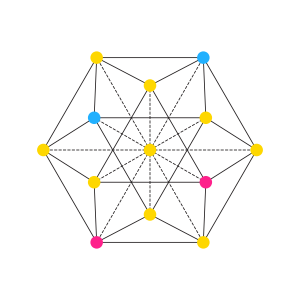

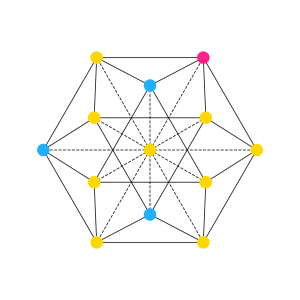

In [26]:
from chemicalmotifidentifier import Plot

plot = Plot(structure='fcc',graph_folder='data/inputs_doi-10.48550-arXiv.2311.01545/graph_plot_templates')
plot.set_colors(np.array(["#FED700", "#21B0FE", "#FE218B"]))
plot.set_node_size(4) 
plot.set_width(0.2) 

for i in [0,1]:
    df_row = df.iloc[i]

    types_with_central_atom = np.concatenate(([df_row.central_atom_type],np.array(list(df_row.shell_atomic_types))))
    
    fig, ax = plt.subplots(figsize=(1,1))
    plot.plot_ms(new_atom_types=types_with_central_atom)
    plt.show()


In [38]:
from chemicalmotifidentifier import Dissimilarity

phys_emb_i =np.concatenate(([df.iloc[0].central_atom_type],df.iloc[0].shell_phys_emb))
phys_emb_j = np.concatenate(([df.iloc[1].central_atom_type],df.iloc[1].shell_phys_emb))

central_atom_dissim,concentration_dissim,structural_dissim, = Dissimilarity().get_separate_dissimilarities(
3, phys_emb_j, phys_emb_i
)
print((central_atom_dissim,concentration_dissim,structural_dissim,))

weights =[1 * 12, 1 * 24 / 12, 24]
d_ij = weights[0]* central_atom_dissim  +  weights[1] * concentration_dissim + weights[2]*structural_dissim


print(f'The dissimilarity between these two motifs is: {d_ij}.')

(array([0]), array([1.]), array([0.28217429]))

The dissimilarity between these two motifs is: [8.77218296].